In [1]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from scipy import stats

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [3]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
assets = '/home/andrey/storage2/andrey/data/projects/24_shift/assets'
paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
bad_clu_dir = '/home/andrey/storage2/andrey/data/projects/24_shift/bad_clusters'

In [4]:
animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']  # all
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  # no 002784
#animals = ['003281', '003282', '003908', '003909', '005363', '005364']

early_per = get_sessions_list(source, animals, 'SHIFT periodic')
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')

## Bad fields

- information content > 0.2
- peak firing rate > 1.5Hz
- isolation distance > 15

In [5]:
def get_idxs_by_quality(dataset):
    sic, pfr, iso = 0.2, 1.5, 15    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sic) & (dataset['sic_B'] > sic)
    idxs_pfr = (dataset['peak_FR_A'] > pfr) & (dataset['peak_FR_B'] > pfr)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [6]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

In [7]:
coherent_AB = get_fields_between_epochs(source, coherent, 'A', 'B')
physical_AB_all = get_fields_between_epochs(source, early_per + periodic + single, 'A', 'B')
visual_AB_s = get_fields_between_epochs(source, visual_s, 'A', 'B')
visual_AB_l = get_fields_between_epochs(source, visual_l, 'A', 'B')
gain_AB_s = get_fields_between_epochs(source, gain_12, 'A', 'B')
gain_AB_l = get_fields_between_epochs(source, gain_14, 'A', 'B')

PF match found for 106 fields from total 194 A and 200 B fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 1520 fields from total 3046 A and 3032 B fields
PF match found for 284 fields from total 513 A and 527 B fields
PF match found for 288 fields from total 516 A and 527 B fields
PF match found for 574 fields from total 1080 A and 1030 B fields
PF match found for 683 fields from total 1484 A and 1452 B fields


In [8]:
gain_AC_s = get_fields_between_epochs(source, gain_12, 'A', 'C')
gain_AC_l = get_fields_between_epochs(source, gain_14, 'A', 'C')

PF match found for 523 fields from total 1080 A and 1010 C fields
PF match found for 630 fields from total 1495 A and 1441 C fields


### shift histogram exp type for each animal

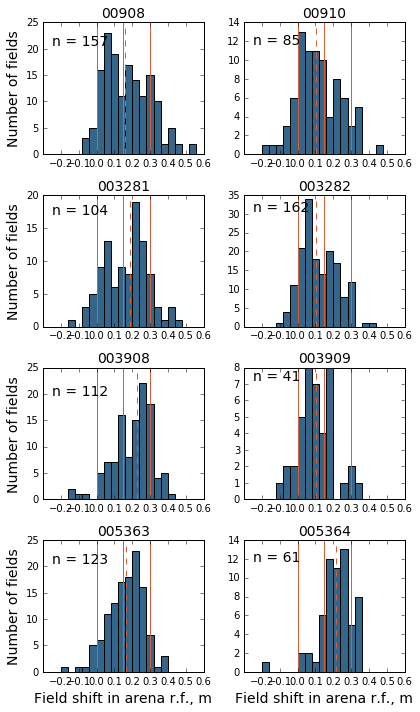

In [13]:
df = physical_AB_all.copy()
#selection = visual_AB_s.copy()
#selection = gain_AB_s.copy()
df = df[get_idxs_of_good_clu(df)]
df = df[get_idxs_by_quality(df)]
#df = selection.copy()

fig = figure(figsize=(6, 10))

collected = []
bins = np.arange(-0.4, 0.6, 0.04)
for i, animal in enumerate(animals):
    data = (-1) * (df[df['animal']==animal]['shift'] - 0.3)  # to arena r.f.
    #data = (-1) * df[df['animal']==animal]['shift'].to_numpy()
    if len(data) == 0:
        continue
    collected.append(data)
    
    ax = fig.add_subplot(4, 2, i+1)
    ax.set_xlim(-0.3, 0.6)
    ax.hist(data, bins=bins, color=COLORS['a'], ec='black')
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(0.15, color=COLORS['b'])    
    ax.axvline(0.3, color=COLORS['b'])
    ax.axvline(np.median(data), color=COLORS['b'], ls='--')
    if i > 5:
        ax.set_xlabel('Field shift in arena r.f., m', fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel('Number of fields', fontsize=14)
    ax.text(-0.25, 0.9 * np.histogram(data, bins)[0].max(), 'n = %d' % len(data), fontsize=14)
    ax.set_title(animal, fontsize=14)
    
fig.tight_layout()
filename = "E_4b.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

### shift histograms animal shift for each exp type

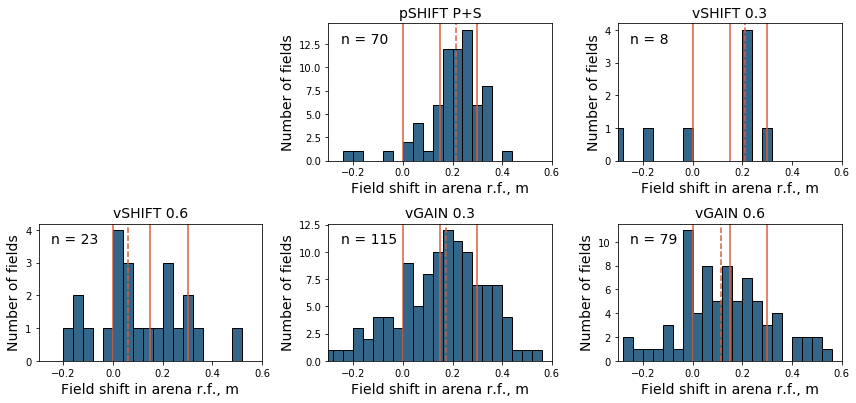

In [81]:
#animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']  # all
animal = '005364'
fig = figure(figsize=(12, 8))

datasets = [coherent_AB, physical_AB_all, visual_AB_s, visual_AB_l, gain_AC_s, gain_AC_l]
titles =   ['pSHIFT Coh', 'pSHIFT P+S', 'vSHIFT 0.3', 'vSHIFT 0.6', 'vGAIN 0.3', 'vGAIN 0.6']
collected = []
bins = np.arange(-0.4, 0.6, 0.04)
for i, dataset in enumerate(datasets):
    idxs = get_idxs_by_quality(dataset)
    df = dataset[idxs]
    
    align = 0.3 if i < 2 else 0
    data = (-1) * (df[df['animal']==animal]['shift'].to_numpy() - align)  # to arena r.f.
    #data = (-1) * df[df['animal']==animal]['shift'].to_numpy()
    if len(data) == 0:
        continue
    collected.append(data)
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xlim(-0.3, 0.6)
    ax.hist(data, bins=bins, color=COLORS['a'], ec='black')
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(0.15, color=COLORS['b'])    
    ax.axvline(0.3, color=COLORS['b'])
    ax.axvline(np.median(data), color=COLORS['b'], ls='--')
    ax.set_xlabel('Field shift in arena r.f., m', fontsize=14)
    ax.set_ylabel('Number of fields', fontsize=14)
    ax.text(-0.25, 0.9 * np.histogram(data, bins)[0].max(), 'n = %d' % len(data), fontsize=14)
    ax.set_title(titles[i], fontsize=14)
    
fig.tight_layout()

In [40]:
st, pv = stats.kruskal(*collected)
"Kruskal: st=%.2f, p=%.8f" % (st, pv)

'Kruskal: st=50.28, p=0.00000004'

In [ ]:
# MOVE to separate notebook
# compute correlations between experimental types!!!

# amount of shift in place fields (for a particular animal) should correlate with shift in behavior
# try to find an integrated metric (occupancy, speed, ..) that describes shift in behavior and correlate it
# with median of the place field shift for diff exp types / animals

### vSHIFT

In [14]:
animals = ['00908', '00910', '002784', '003281', '003282', '003909', '005363', '005364']

s_list_l = get_sessions_list(source, animals, 'SHIFT visual')
s_list_s = get_sessions_list(source, animals, 'SHIFT visual +dark')
AB = get_fields_between_epochs(source, list(s_list_l) + (s_list_s), 'A', 'B')

print('Found %s sessions' % len(s_list_s) + len(s_list_l))

PF match found for 291 fields from total 564 A and 592 B fields
Found 7 sessions


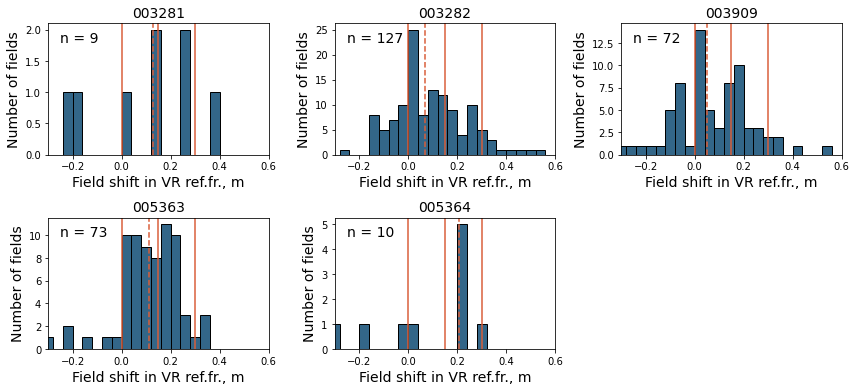

In [22]:
idxs = get_idxs_by_quality(AB)
#df = AB[idxs]
df = AB.copy()

fig = figure(figsize=(12, 8))

bins = np.arange(-0.4, 0.6, 0.04)
for i, animal in enumerate(animals):
    if not len(df[df['animal']==animal]) > 0:
        continue
    
    data = (-1) * df[df['animal']==animal]['shift'].to_numpy()
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xlim(-0.3, 0.6)
    ax.hist(data, bins=bins, color=COLORS['a'], ec='black')
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(0.15, color=COLORS['b'])    
    ax.axvline(0.3, color=COLORS['b'])
    ax.axvline(np.median(data), color=COLORS['b'], ls='--')
    ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
    ax.set_ylabel('Number of fields', fontsize=14)
    ax.text(-0.25, 0.9 * np.histogram(data, bins)[0].max(), 'n = %d' % len(data), fontsize=14)
    ax.set_title(animal, fontsize=14)
    
fig.tight_layout()

In [23]:
### GAIN

In [24]:
animals = ['003908', '003909', '005363', '005364']  # last four, add '003908', '003909'

sessions_12 = list(get_sessions_list(source, animals, 'GAIN 3 parts 1.2x'))
AB = get_fields_between_epochs(source, sessions_12, 'A', 'B')

PF match found for 574 fields from total 1080 A and 1030 B fields


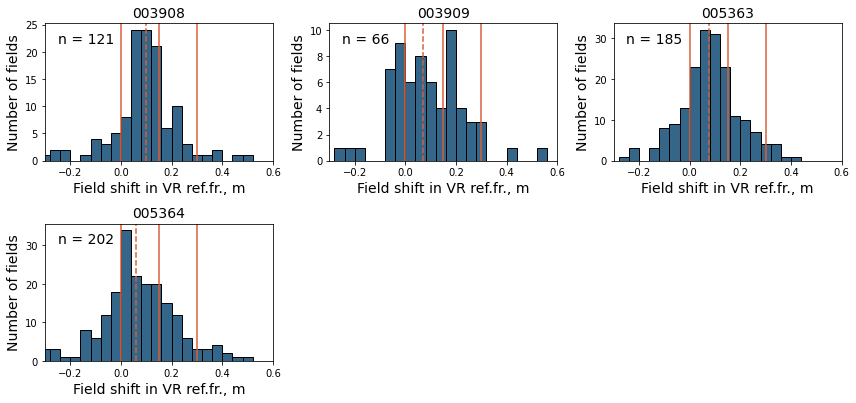

In [28]:
df = AB.copy()

fig = figure(figsize=(12, 8))

bins = np.arange(-0.4, 0.6, 0.04)
for i, animal in enumerate(animals):
    if not len(df[df['animal']==animal]) > 0:
        continue
    
    data = (-1) * df[df['animal']==animal]['shift'].to_numpy()
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.set_xlim(-0.3, 0.6)
    ax.hist(data, bins=bins, color=COLORS['a'], ec='black')
    ax.axvline(0, color=COLORS['b'])
    ax.axvline(0.15, color=COLORS['b'])    
    ax.axvline(0.3, color=COLORS['b'])
    ax.axvline(np.median(data), color=COLORS['b'], ls='--')
    ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
    ax.set_ylabel('Number of fields', fontsize=14)
    ax.text(-0.25, 0.9 * np.histogram(data, bins)[0].max(), 'n = %d' % len(data), fontsize=14)
    ax.set_title(animal, fontsize=14)
    
fig.tight_layout()